# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

### Team 30

Students:

- Juan Manuel Carballo          A01166758
- Paola Estrada Warn            A01795663
- Christopher Flores González   A01795419
- Jorge Pedroza Rivera          A01319553
- Victor Hugo Avila Felipe      A01794425

In [1]:
%pip install -q numpy
%pip install -q matplotlib
%pip install -q torchinfo
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchinfo import summary

Detect the device used for training (mps, cpu or cuda)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cuda':
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
print(f"Available device: {device.type}")

Available device: cuda


## Dataset acquisition and exploration

Create a compose transformation to convert each image to pytorch tensor and normalization according to ImageNet images mean and std.

In [4]:
dataset_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Download CIFAR10 dataset using the datasets package from pytorch

In [5]:
DATA_PATH = '../cifar10'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=dataset_transform)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=dataset_transform)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=dataset_transform)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Show a random image from the test partition dataset

The image represents a class of: horse


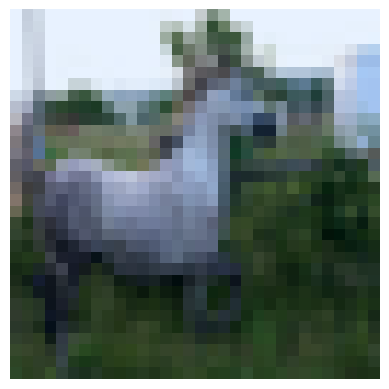

In [6]:
classes = test_loader.dataset.classes
num_classes = len(test_loader.dataset.classes)

def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'The image represents a class of: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


Plot a random image sample from the 10 categories of CIFAR10 dataset

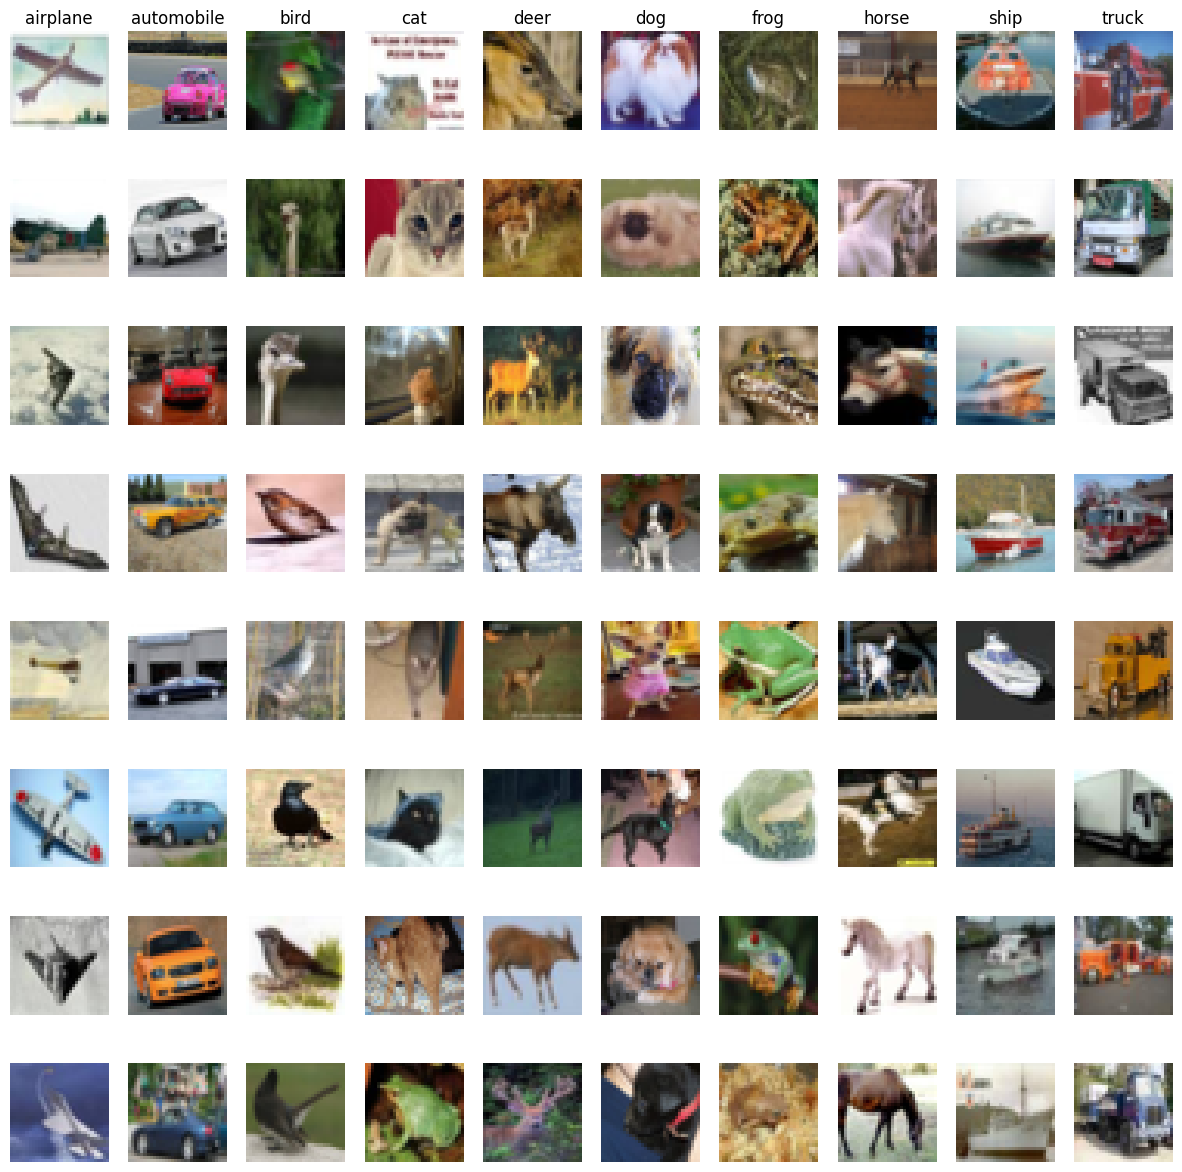

In [7]:
def plot_cifar10_grid(dataloader: DataLoader):
    classes = dataloader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(dataloader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(dataloader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid(test_loader)

## Model Training

Definition of accuracy function

In [8]:
def accuracy(loader: DataLoader, model, transform_fn, device):
    """Computes model accuracy for a specific partition dataset

    Args:
        loader (DataLoader): the dataloader to compute the accuracy
        model (nn.Module): the module to use to compute the
        transform_fn (function): transform the minibatch before passing it to the model
        device (device): the underlying device used for computing

    Returns:
        accuracy: the mean accuracy
    """
    model.eval()
    total, correct = 0., 0.
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # transform input
            if transform_fn is not None:
                X = transform_fn(X)
            # predict
            scores = model(X)
            # calculate acc
            _, y_pred = scores.max(dim=1)
            correct += (y_pred == y).sum()
            total += y_pred.size(0)

        print(f" avg accuracy={100 * (correct/total):>0.1f}%")
        return (correct/total).detach().cpu().numpy()

In [9]:
def train_batch(loader: DataLoader, model, optimizer, transform_fn, device):
    """Computes a train epoch

    Args:
        loader (DataLoader): the dataloader used for training the model
        model (nn.Module): the module to train
        optimizer (Optimizer): the optimizer to use for backpropagation
        transform_fn (function): transform the minibatch before passing it to the model
        device (device): the underlying device used for computing

    Returns:
        loss: the mean loss for this epoch
    """
    size = len(loader.dataset)
    losses = []    
    for batch, (X, y) in enumerate(loader):
        model.train()
        X, y = X.to(device), y.to(device)
        # transform input
        if transform_fn is not None:
            X = transform_fn(X)
        scores = model(X)
        # calculate loss and accuracy
        loss = F.cross_entropy(scores, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.reshape(1))
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss={loss:>7f} [{current:>5d}/{size:>5d}]")

    return torch.mean(torch.cat(losses)).item()

def test_batch(loader: DataLoader, model, transform_fn, device):
    """Computes a test epoch

    Args:
        loader (DataLoader): the dataloader used for testing the model
        model (nn.Module): the module to test
        transform_fn (function): transform the minibatch before passing it to the model
        device (device): the underlying device used for computing

    Returns:
        loss: the mean loss for this epoch
    """
    model.eval()
    losses = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # transform input
            if transform_fn is not None:
                X = transform_fn(X)
            # predict
            scores = model(X)
            # calculate loss
            loss = F.cross_entropy(scores, y)
            losses.append(loss.reshape(1))
        
        mean_loss = torch.mean(torch.cat(losses)).item()
    print(f"Test:\n avg loss={mean_loss:>8f}")
    return mean_loss

In [10]:
def train(epochs, train_dataloader: DataLoader, val_dataloader: DataLoader, model, optimizer, transform_fn, device):
    """Trains a specific model for n epochs

    Args:
        epochs (int): the total iterations to train the model
        train_dataloader (DataLoader): the dataloader used for training the model
        val_dataloader (DataLoader): the dataloader used for testing the model
        model (nn.Module): the module to train
        optimizer (optimizer): the optimizer to use for backpropagation
        transform_fn (function): transform the minibatch before passing it to the model
        device (device): the underlying device used for computing

    Returns:
        train loss: the train losses across all the epochs
        test loss: the test losses across all the epochs
        accuracies: the accuracy for train and test across all the epochs
    """
    train_losses = []
    test_losses = []
    accuracies = []
    for t in range(epochs):
        print(f"\nEpoch {t+1}\n---------------------------")
        train_loss = train_batch(train_dataloader, model, optimizer, transform_fn, device)
        print("Train:")
        train_acc = accuracy(train_dataloader, model, transform_fn, device)
        test_loss = test_batch(val_dataloader, model, transform_fn, device)
        test_acc = accuracy(val_dataloader, model, transform_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append([train_acc, test_acc])
    print("Done!\n\n")
    return train_losses, test_losses, accuracies

## Baseline Model

Using a fully connected neural network with Linear, Dropout and Relu.

In [11]:
class BaselineModel(nn.Module):
    
    def __init__(self, num_classes, image_size=(32,32,3)) -> None:
        super(BaselineModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(torch.prod(torch.tensor(image_size)), 2048),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, X):
        return self.seq(X)

In [12]:
lr_model = BaselineModel(num_classes)

In [13]:
summary(lr_model, input_data=torch.ones(64,3072), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
BaselineModel                            [64, 3072]                [64, 10]                  --
├─Sequential: 1-1                        [64, 3072]                [64, 10]                  --
│    └─Linear: 2-1                       [64, 3072]                [64, 2048]                6,293,504
│    └─Dropout: 2-2                      [64, 2048]                [64, 2048]                --
│    └─ReLU: 2-3                         [64, 2048]                [64, 2048]                --
│    └─Linear: 2-4                       [64, 2048]                [64, 1024]                2,098,176
│    └─ReLU: 2-5                         [64, 1024]                [64, 1024]                --
│    └─Linear: 2-6                       [64, 1024]                [64, 10]                  10,250
Total params: 8,401,930
Trainable params: 8,401,930
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 53

The training is executed with three different optimizers SGD with momentum, RMSProp and Adam using the default parameters

In [17]:
epochs = 5
accuracy_list = []
for name, Opt in [("SGD", torch.optim.SGD), ("RMSProp", torch.optim.RMSprop), ("Adam", torch.optim.Adam)]:
    print(f"Using {name} optimizer\n")

    model = BaselineModel(num_classes).to(device)
    optimizer = Opt(model.parameters(), momentum=0.9, lr=1e-4) if name == "SGD" else Opt(model.parameters(), lr=1e-4)

    _, _, acc = train(epochs, train_loader, val_loader, model, optimizer, transform_fn=lambda X: torch.reshape(X, (X.size(0), 3072)), device=device)
    accuracy_list.append(acc)

Using SGD optimizer


Epoch 1
---------------------------
loss=2.316495 [   64/50000]
loss=2.259021 [ 6464/50000]
loss=2.224286 [12864/50000]
loss=2.214454 [19264/50000]
loss=2.196198 [25664/50000]
loss=2.122360 [32064/50000]
loss=2.106648 [38464/50000]
loss=2.037059 [44864/50000]
Train:
 avg accuracy=28.9%
Test:
 avg loss=2.057158
 avg accuracy=29.2%

Epoch 2
---------------------------
loss=2.035810 [   64/50000]
loss=1.949450 [ 6464/50000]
loss=2.185290 [12864/50000]
loss=2.096412 [19264/50000]
loss=1.942405 [25664/50000]
loss=2.003026 [32064/50000]
loss=2.022411 [38464/50000]
loss=1.907382 [44864/50000]
Train:
 avg accuracy=32.5%
Test:
 avg loss=1.933776
 avg accuracy=32.8%

Epoch 3
---------------------------
loss=1.898392 [   64/50000]
loss=1.767734 [ 6464/50000]
loss=1.843656 [12864/50000]
loss=1.977952 [19264/50000]
loss=1.909614 [25664/50000]
loss=1.953905 [32064/50000]
loss=1.836409 [38464/50000]
loss=1.746016 [44864/50000]
Train:
 avg accuracy=35.2%
Test:
 avg loss=1.855659


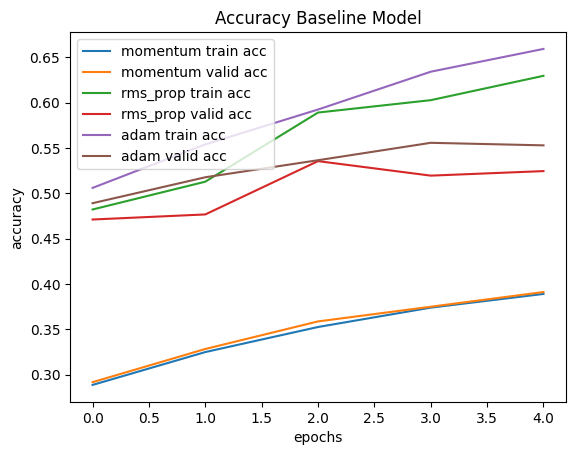

In [18]:
sgd_momentum = np.array(accuracy_list[0])
rms_prop = np.array(accuracy_list[1])
adam = np.array(accuracy_list[2])

plt.plot(np.arange(epochs), sgd_momentum[:,0], label="momentum train acc")
plt.plot(np.arange(epochs), sgd_momentum[:,1], label="momentum valid acc")
plt.plot(np.arange(epochs), rms_prop[:,0], label="rms_prop train acc")
plt.plot(np.arange(epochs), rms_prop[:,1], label="rms_prop valid acc")
plt.plot(np.arange(epochs), adam[:,0], label="adam train acc")
plt.plot(np.arange(epochs), adam[:,1], label="adam valid acc")
plt.legend()
plt.title("Accuracy Baseline Model")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

From the previous experiment decided to use SGD with momentum to train the model with a larger epoch size without overfitting the model the results are displayed after the training logs.

In [21]:
epochs = 20
model = BaselineModel(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=1e-4)

train_loss, test_loss, acc = train(epochs, train_loader, val_loader, model, optimizer, transform_fn=lambda X: torch.reshape(X, (X.size(0), 3072)), device=device)


Epoch 1
---------------------------
loss=2.321220 [   64/50000]
loss=2.260962 [ 6464/50000]
loss=2.208245 [12864/50000]
loss=2.197198 [19264/50000]
loss=2.114371 [25664/50000]
loss=2.126602 [32064/50000]
loss=2.159349 [38464/50000]
loss=2.036199 [44864/50000]
Train:
 avg accuracy=29.2%
Test:
 avg loss=2.063810
 avg accuracy=29.4%

Epoch 2
---------------------------
loss=2.049616 [   64/50000]
loss=1.998456 [ 6464/50000]
loss=2.015747 [12864/50000]
loss=2.078017 [19264/50000]
loss=1.964234 [25664/50000]
loss=1.877101 [32064/50000]
loss=1.950388 [38464/50000]
loss=2.038001 [44864/50000]
Train:
 avg accuracy=32.6%
Test:
 avg loss=1.932019
 avg accuracy=33.0%

Epoch 3
---------------------------
loss=1.867777 [   64/50000]
loss=1.943304 [ 6464/50000]
loss=1.953966 [12864/50000]
loss=1.711946 [19264/50000]
loss=1.944234 [25664/50000]
loss=1.875515 [32064/50000]
loss=1.789838 [38464/50000]
loss=1.810300 [44864/50000]
Train:
 avg accuracy=35.5%
Test:
 avg loss=1.847745
 avg accuracy=36.0%



Plot the Results for Baseline Model

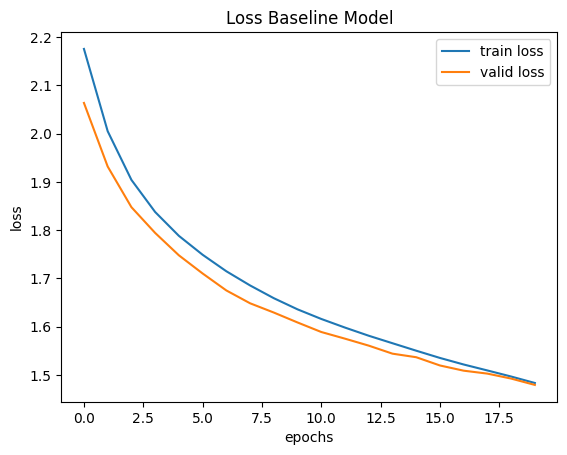

In [22]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

plt.plot(np.arange(epochs), train_loss, label="train loss")
plt.plot(np.arange(epochs), test_loss, label="valid loss")
plt.legend()
plt.title("Loss Baseline Model")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

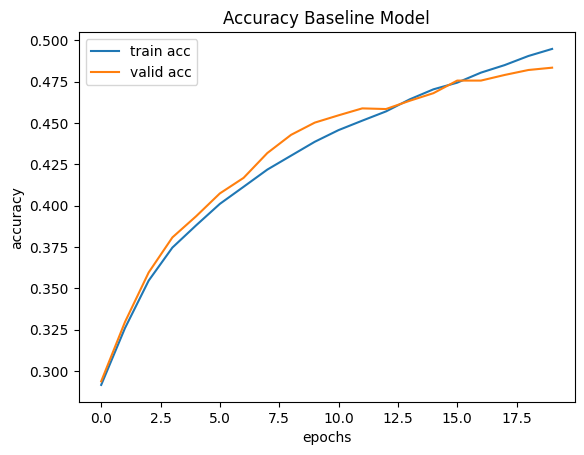

In [23]:
acc = np.array(acc)


plt.plot(np.arange(epochs), acc[:,0], label="train acc")
plt.plot(np.arange(epochs), acc[:,1], label="valid acc")
plt.legend()
plt.title("Accuracy Baseline Model")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

From the previous experiment we saw the model was not learning fast enough making us think the model is not enough complex for learning the features for this dataset so our next aproach is to try convolutional neural networks

## Convolutional Neural Network

Neural Network using 2d convolution layers, 2d batch norm layers, 2d max pool layers, and linear layer using ReLU activation. We picked 2d convolutional layers because the datasets is primarily formed by images and this layer is suited for working with images using less trainable parameters, batch norm layers were used to avoid potential overfitting and perform normalization from the activations of the previous layer to the input of the next layer, applied relu activation for discarding negative values and help us to overcome the vanishing gradient problem and finally we use max pool layers for reducing the spatial dimension of the feature maps after a set or conv-batch-relu layer.

In [27]:
class ImageNet(nn.Module):
    
    def __init__(self, num_classes) -> None:
        super(ImageNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.max_pool1 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.max_pool2 = nn.MaxPool2d(2,2)        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 4092)
        self.fc2 = nn.Linear(4092, num_classes)
        

    def forward(self, image):
        x = F.relu(self.bn1(self.conv1(image)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.max_pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.max_pool2(x)
        
        x = F.relu(self.fc1(self.flatten(x)))
        x = self.fc2(x)
        return x

In [28]:
conv_model = ImageNet(num_classes)
summary(conv_model, input_data=torch.ones(MINIBATCH_SIZE,3,32,32), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ImageNet                                 [64, 3, 32, 32]           [64, 10]                  --
├─Conv2d: 1-1                            [64, 3, 32, 32]           [64, 16, 32, 32]          448
├─BatchNorm2d: 1-2                       [64, 16, 32, 32]          [64, 16, 32, 32]          32
├─Conv2d: 1-3                            [64, 16, 32, 32]          [64, 32, 32, 32]          4,640
├─BatchNorm2d: 1-4                       [64, 32, 32, 32]          [64, 32, 32, 32]          64
├─MaxPool2d: 1-5                         [64, 32, 32, 32]          [64, 32, 16, 16]          --
├─Conv2d: 1-6                            [64, 32, 16, 16]          [64, 64, 16, 16]          18,496
├─BatchNorm2d: 1-7                       [64, 64, 16, 16]          [64, 64, 16, 16]          128
├─Conv2d: 1-8                            [64, 64, 16, 16]          [64, 128, 16, 16]         73,856
├─BatchNorm2d: 1-9    

Train the CNN model for 15 epochs using SGD with momentum and a learning rate of $0.0001$

In [29]:
epochs = 15
imageNet = ImageNet(num_classes).to(device)
optimizer = torch.optim.SGD(imageNet.parameters(), momentum=0.9, lr=1e-4)

train_loss, test_loss, acc = train(epochs, train_loader, val_loader, imageNet, optimizer, transform_fn=None, device=device)


Epoch 1
---------------------------
loss=2.380283 [   64/50000]
loss=2.060368 [ 6464/50000]
loss=1.959178 [12864/50000]
loss=1.774985 [19264/50000]
loss=1.816594 [25664/50000]
loss=1.571557 [32064/50000]
loss=1.524531 [38464/50000]
loss=1.609833 [44864/50000]
Train:
 avg accuracy=48.0%
Test:
 avg loss=1.503048
 avg accuracy=49.0%

Epoch 2
---------------------------
loss=1.399039 [   64/50000]
loss=1.516618 [ 6464/50000]
loss=1.334514 [12864/50000]
loss=1.393772 [19264/50000]
loss=1.355786 [25664/50000]
loss=1.402538 [32064/50000]
loss=1.499732 [38464/50000]
loss=1.447060 [44864/50000]
Train:
 avg accuracy=54.2%
Test:
 avg loss=1.311091
 avg accuracy=54.4%

Epoch 3
---------------------------
loss=1.229841 [   64/50000]
loss=1.292826 [ 6464/50000]
loss=1.279673 [12864/50000]
loss=1.396108 [19264/50000]
loss=1.383590 [25664/50000]
loss=1.213877 [32064/50000]
loss=1.211340 [38464/50000]
loss=1.276477 [44864/50000]
Train:
 avg accuracy=58.2%
Test:
 avg loss=1.212730
 avg accuracy=58.2%



Plot the loss and accuracy for the CNN model

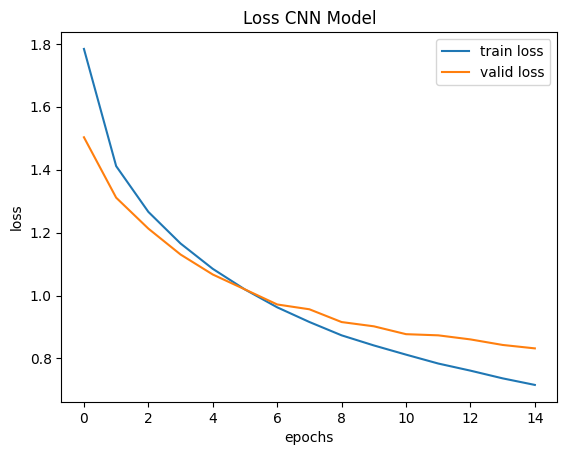

In [30]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

plt.plot(np.arange(epochs), train_loss, label="train loss")
plt.plot(np.arange(epochs), test_loss, label="valid loss")
plt.legend()
plt.title("Loss CNN Model")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

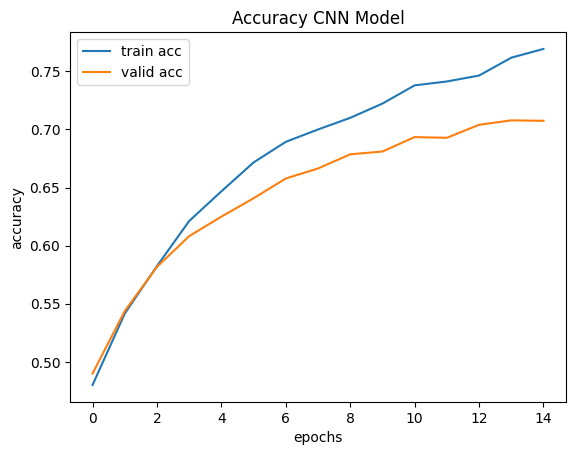

In [31]:
acc = np.array(acc)


plt.plot(np.arange(epochs), acc[:,0], label="train acc")
plt.plot(np.arange(epochs), acc[:,1], label="valid acc")
plt.legend()
plt.title("Accuracy CNN Model")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

From the results above the model reached a 76.9% and 70.7% of accuracy in the train and validation models.

## Test the Model

Create of a denormalization function for bringing back the correct pixel values for visulization

In [32]:
denormalize = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255])

Print the accuracy of the CNN model using the test partition dataset

In [33]:
print("ImageNet:")
_ = accuracy(test_loader, imageNet, transform_fn=None, device=device)

ImageNet:
 avg accuracy=70.7%


In [34]:
model = imageNet

Use the model to predict the output of an random choosen image from the test partition dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014133327..1.0792].


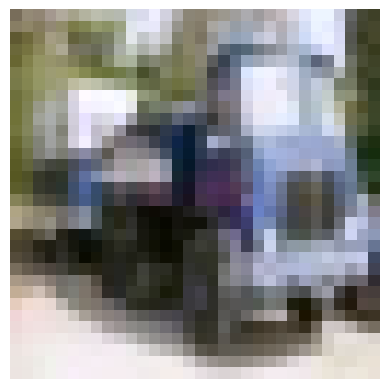

La imagen muestreada representa un: truck
El modelo classifico la imagen como: truck


In [35]:
rnd_sample_idx = np.random.randint(len(test_loader))

image = test_loader.dataset[rnd_sample_idx][0]
image = image.to(device)

pred = torch.argmax(model(torch.reshape(image, shape=(1,) + image.shape)), dim=1)

plot_figure(denormalize(image.cpu()))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
print(f'El modelo classifico la imagen como: {classes[pred]}')